In [1]:
from matplotlib.colors import ListedColormap
import pystac_client

import numpy as np
import pandas as pd
import planetary_computer
import rasterio
from shapely import Polygon

import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt

from shapely import box
from IPython.display import Image  # To nicely display images

## Import Thomas fire perimeter

<Axes: >

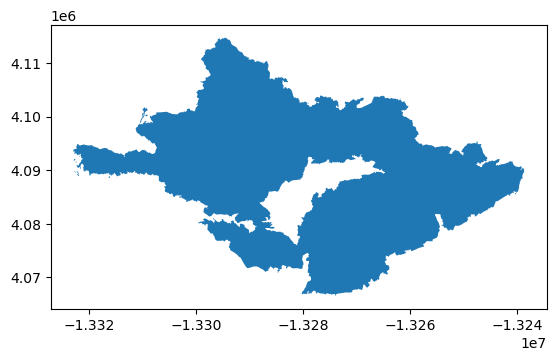

In [2]:
fire_perimeters = gpd.read_file('data/California_Fire_Perimeters_2017/California_Fire_Perimeters_2017.shp')
thomas_fire = fire_perimeters[fire_perimeters['FIRE_NAME']=='THOMAS']
thomas_fire.plot()

In [29]:
# Examine CRS of boundary
thomas_fire.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Retrieve LULC data over fire perimeter

In [3]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
# Reproject fire perimeter to match CRS needed for search
thomas_fire = thomas_fire.to_crs('epsg:4326')

# Create bounding box for search
thomas_fire_bbox = list(thomas_fire.total_bounds)

search = catalog.search(collections=['gap'], 
                        bbox=thomas_fire_bbox)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 1 Items


## Explore LULC item around Thomas Fire perimeter

In [5]:
item = items[0]  # Select item

# Display pre-rendered image
Image(url=item.assets['rendered_preview'].href)

In [6]:
# Access raster data from item
lulc = rioxr.open_rasterio(item.assets['data'].href)
lulc

<xarray.DataArray (band: 1, y: 10000, x: 10000)> Size: 200MB
[100000000 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 80kB -2.361e+06 -2.361e+06 ... -2.061e+06
  * y            (y) float64 80kB 1.762e+06 1.762e+06 ... 1.462e+06 1.462e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

Let's visually explore the extent of the `lulc23` tile relative to the CA boundary:

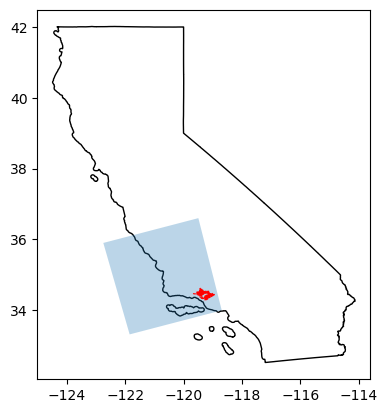

In [34]:
# Create GeoDataFrame from raster bounding box
lulc_bbox = gpd.GeoDataFrame(geometry = [box(*lulc.rio.bounds())],
                 crs = lulc.rio.crs)
ca = gpd.read_file('data/ca_state_boundary/ca_state_boundary.shp')

# Plot raster boundary, fire perimeter, and CA boundary
fig, ax = plt.subplots()
ca.plot(ax=ax, color='white', edgecolor ='black')
lulc_bbox.to_crs(ca.crs).plot(ax=ax, alpha=0.3)   # Reproject to match CA crs
thomas_fire.to_crs(ca.crs).plot(ax=ax, color='red')
plt.show()

## Clip raster to fire perimeter

First, we need to ensure our raster and fire perimeter have the same CRS.

In [7]:
thomas_fire_match = thomas_fire.to_crs(lulc.rio.crs)
assert thomas_fire_match.crs == lulc.rio.crs

Clipping directly with the fire perimeter is computationally expensive. It is best to first reduce with the `thomas_fire` bounding box, and then clip to the actual fire perimeter.

In [8]:
lulc_clip = lulc.rio.clip_box(*thomas_fire_match.total_bounds)

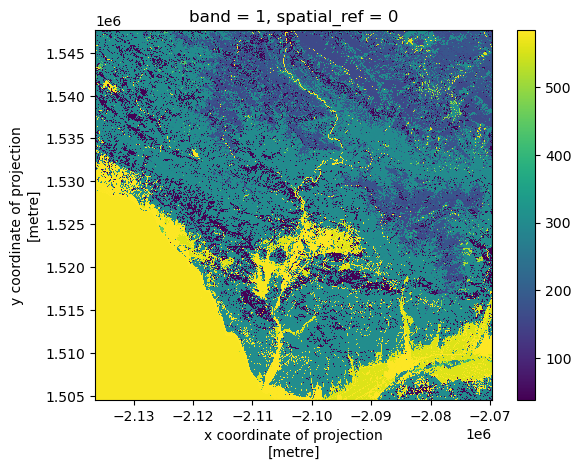

In [9]:
lulc_clip.plot()

In [38]:
lulc_thomasfire = lulc_clip.rio.clip(thomas_fire_match.geometry)

/Users/galaz-garcia/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


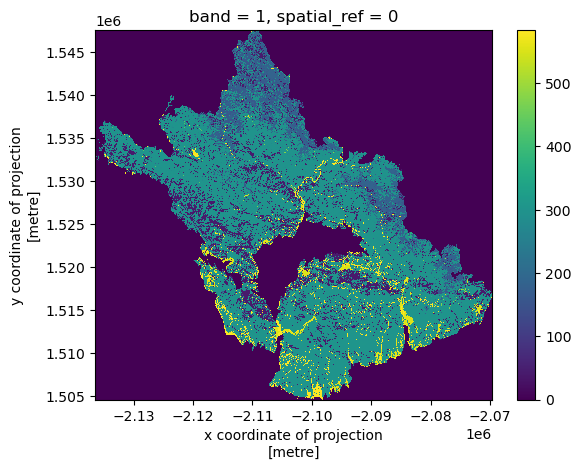

In [39]:
lulc_thomasfire.plot()

In [10]:
lulc_clip = lulc_clip.rio.write_nodata(0)
lulc_clip.rio.nodata

0

In [11]:
lulc_thomasfire = lulc_clip.rio.clip(thomas_fire_match.geometry)

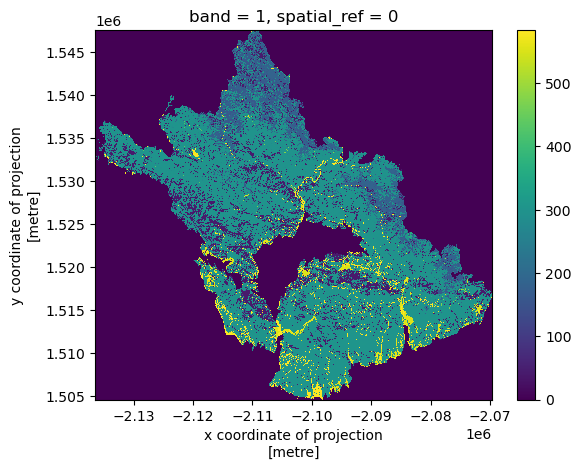

In [12]:
lulc_thomasfire.plot()

In [16]:
lulc_clip.dtype

dtype('uint16')

## Save and reopen

In [21]:
lulc_thomasfire.rio.to_raster('USGS_National_Terrestrial_Ecosystems_Over_Thomas_Fire_Perimeter.tif')

In [22]:
reopen = rioxr.open_rasterio('USGS_National_Terrestrial_Ecosystems_Over_Thomas_Fire_Perimeter.tif')
reopen

<xarray.DataArray (band: 1, y: 1434, x: 2228)> Size: 6MB
[3194952 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 18kB -2.136e+06 -2.136e+06 ... -2.07e+06 -2.07e+06
  * y            (y) float64 11kB 1.548e+06 1.548e+06 ... 1.505e+06 1.505e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    _FillValue:              0
    scale_factor:            1.0
    add_offset:              0.0

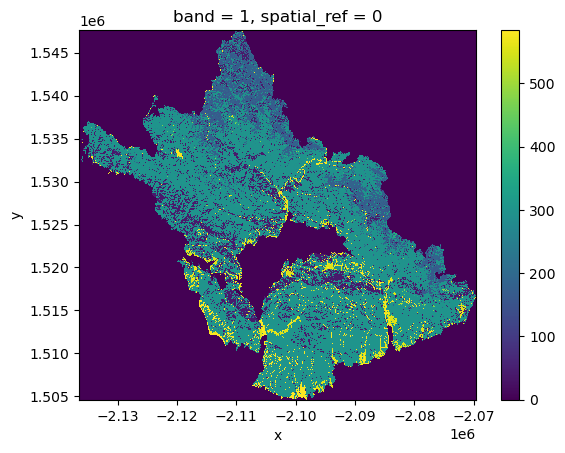

In [23]:
reopen.plot()

## Reprojection

In [13]:
reprojected = lulc_thomasfire.rio.reproject(thomas_fire.crs)

In [14]:
## How does the reprojection affect the data values?
np.unique(reprojected)

array([  0,  39,  40,  41,  42,  43,  45,  55, 159, 162, 165, 183, 277,
       278, 282, 296, 297, 300, 302, 303, 304, 305, 359, 360, 383, 385,
       432, 470, 472, 485, 489, 516, 539, 540, 547, 552, 553, 556, 557,
       558, 567, 568, 578, 579, 581, 582, 583, 584], dtype=uint16)

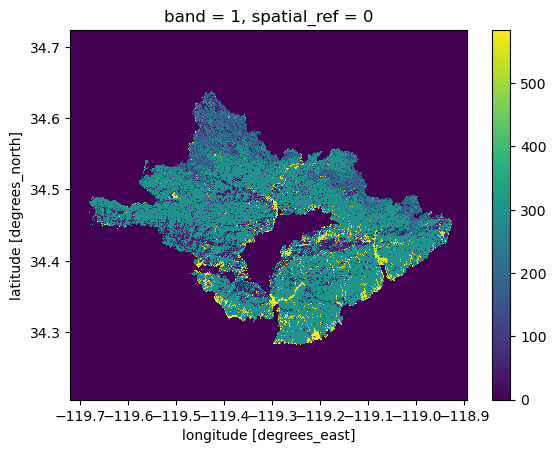

In [15]:
reprojected.plot()

## Land cover statistics

In [46]:
labels = pd.read_csv('data/GAP_National_Terrestrial_Ecosystems.csv')
labels.head()

,class_label,code
0,0,0
1,South Florida Bayhead Swamp,1
2,South Florida Cypress Dome,2
3,South Florida Dwarf Cypress Savanna,3
4,South Florida Mangrove Swamp,4


In [47]:
unique_counts = np.unique(lulc_thomasfire, return_counts=True)

pix_counts = pd.DataFrame({'code':unique_counts[0], 
                           'n_pixels':unique_counts[1]})
pix_counts = pix_counts[pix_counts['code']!=0]
pix_counts

,code,n_pixels
1,39,6856
2,40,361
3,41,133704
4,42,3638
5,43,23150
6,45,2907
7,55,4974
8,159,3727
9,162,60203
10,165,5102


In [48]:
classes = pd.merge(left=labels, 
                   right=pix_counts, 
                   on='code')
classes

,class_label,code,n_pixels
0,California Central Valley Mixed Oak Savanna,39,6856
1,California Coastal Closed-Cone Conifer Forest ...,40,361
2,California Coastal Live Oak Woodland and Savanna,41,133704
3,California Lower Montane Blue Oak-Foothill Pin...,42,3638
4,Central and Southern California Mixed Evergree...,43,23150
5,Southern California Oak Woodland and Savanna,45,2907
6,Mediterranean California Mixed Evergreen Forest,55,4974
7,California Montane Jeffrey Pine-(Ponderosa Pin...,159,3727
8,Mediterranean California Dry-Mesic Mixed Conif...,162,60203
9,California Coastal Redwood Forest,165,5102


In [56]:
# What percentage of the area defined by the fire perimeter was estimated to be developed (categories 44-47)
area_per_pixel = 30**2  # In meters^2
classes.iloc[43:47].n_pixels.sum() * area_per_pixel / 1000**2

40.7898

In [50]:
# What were the top 10 habitats most affected by the fire ? OR sth like that

In [58]:
total_pixels = classes.n_pixels.sum()
total_pixels

1267082

Object `classes.order` not found.


In [60]:
classes['percentage'] = classes.n_pixels/total_pixels * 100

,class_label,code,n_pixels,percentage
0,California Central Valley Mixed Oak Savanna,39,6856,0.541086
1,California Coastal Closed-Cone Conifer Forest ...,40,361,0.028491
2,California Coastal Live Oak Woodland and Savanna,41,133704,10.552119
3,California Lower Montane Blue Oak-Foothill Pin...,42,3638,0.287116
4,Central and Southern California Mixed Evergree...,43,23150,1.827033
5,Southern California Oak Woodland and Savanna,45,2907,0.229425
6,Mediterranean California Mixed Evergreen Forest,55,4974,0.392555
7,California Montane Jeffrey Pine-(Ponderosa Pin...,159,3727,0.294140
8,Mediterranean California Dry-Mesic Mixed Conif...,162,60203,4.751310
9,California Coastal Redwood Forest,165,5102,0.402657


In [71]:
classes = classes.sort_values(by='percentage', ascending=True)

<Axes: ylabel='class_label'>

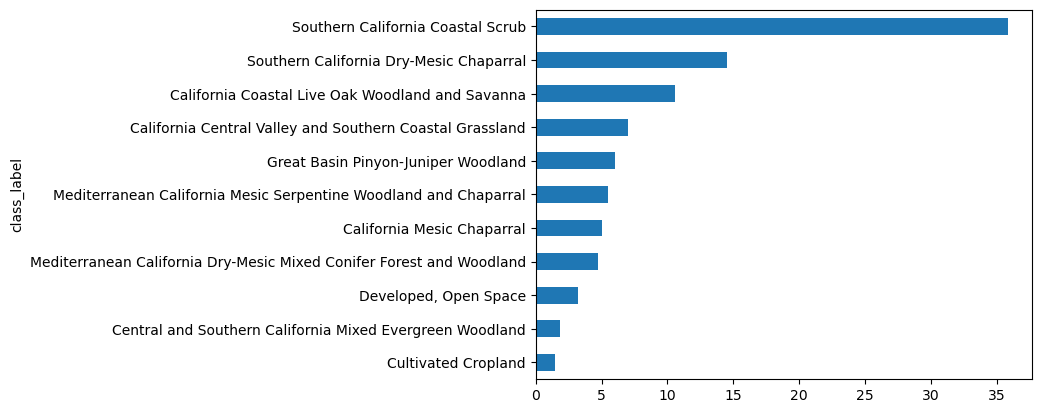

In [72]:
classes[classes['percentage']>1].set_index('class_label').percentage.plot(kind='barh')

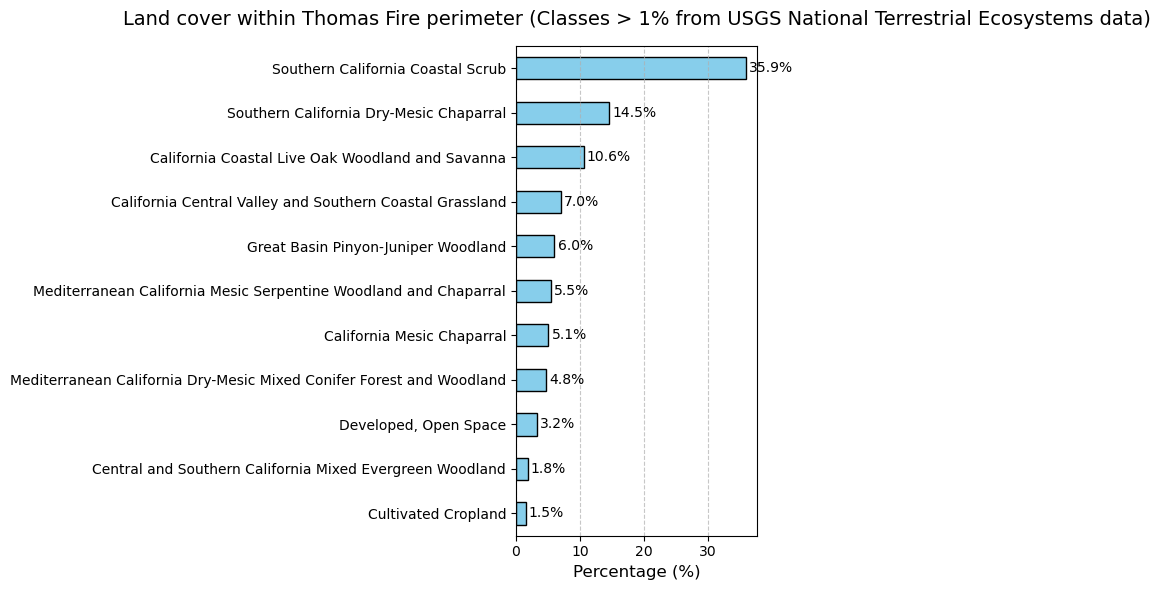

In [78]:
# Filter and set index as in the original code
filtered_classes = classes[classes['percentage'] > 1].set_index('class_label')

# Create the horizontal plot
ax = filtered_classes.percentage.plot(kind='barh', 
            figsize=(8, 6), 
            color='skyblue', 
            edgecolor='black')

# Add title and axis labels
ax.set_title('Land cover within Thomas Fire perimeter (Classes > 1% from USGS National Terrestrial Ecosystems data)', 
            fontsize=14, 
            pad=15
            )
ax.set_xlabel('Percentage (%)', fontsize=12)
ax.set_ylabel('')

# Add gridlines for easier interpretation
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage values to the bars
for i, v in enumerate(filtered_classes.percentage):
    ax.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

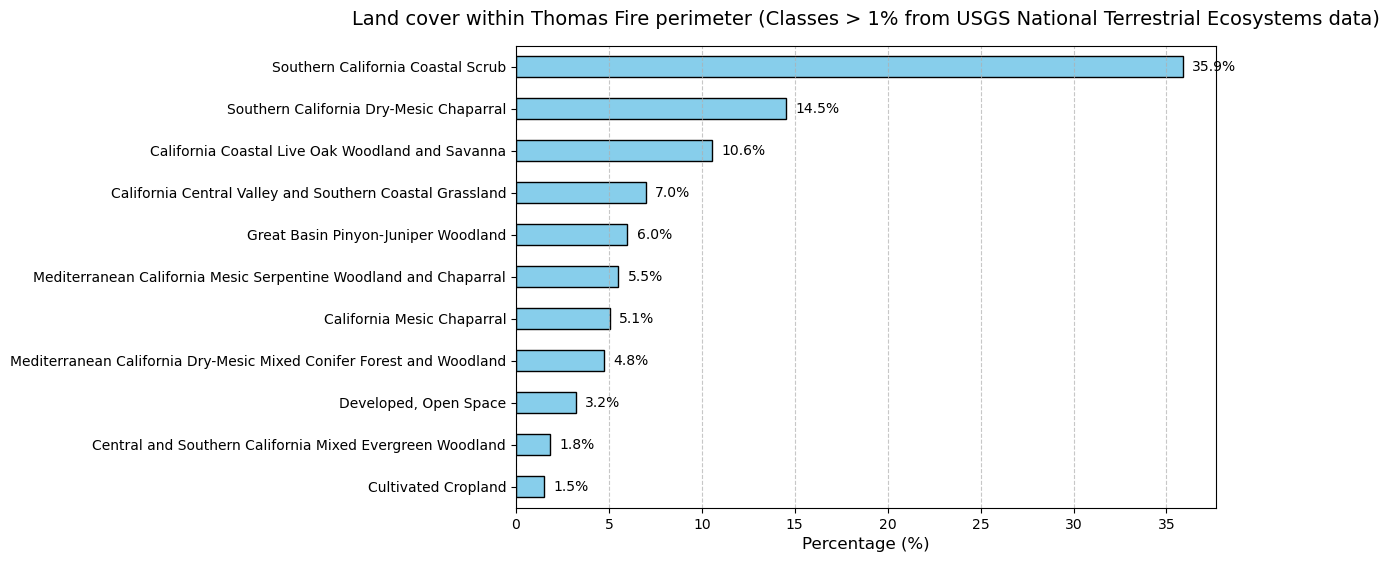

In [79]:
# Filter and set index as in the original code
filtered_classes = classes[classes['percentage'] > 1].set_index('class_label')

# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted figure size for better proportions

# Plot with improved style
filtered_classes.percentage.plot(
    kind='barh',
    ax=ax,
    color='skyblue',
    edgecolor='black'
)

# Add title and axis labels
ax.set_title(
    'Land cover within Thomas Fire perimeter (Classes > 1% from USGS National Terrestrial Ecosystems data)',
    fontsize=14,
    pad=15
)
ax.set_xlabel('Percentage (%)', fontsize=12)
ax.set_ylabel('')  # No label for y-axis

# Add gridlines for easier interpretation
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage values to the bars
for i, v in enumerate(filtered_classes.percentage):
    ax.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=10)

# Make the axis box wider relative to the figure area
fig.subplots_adjust(left=0.25, right=0.95)  # Adjust space around the plot

# Show the plot
plt.show()


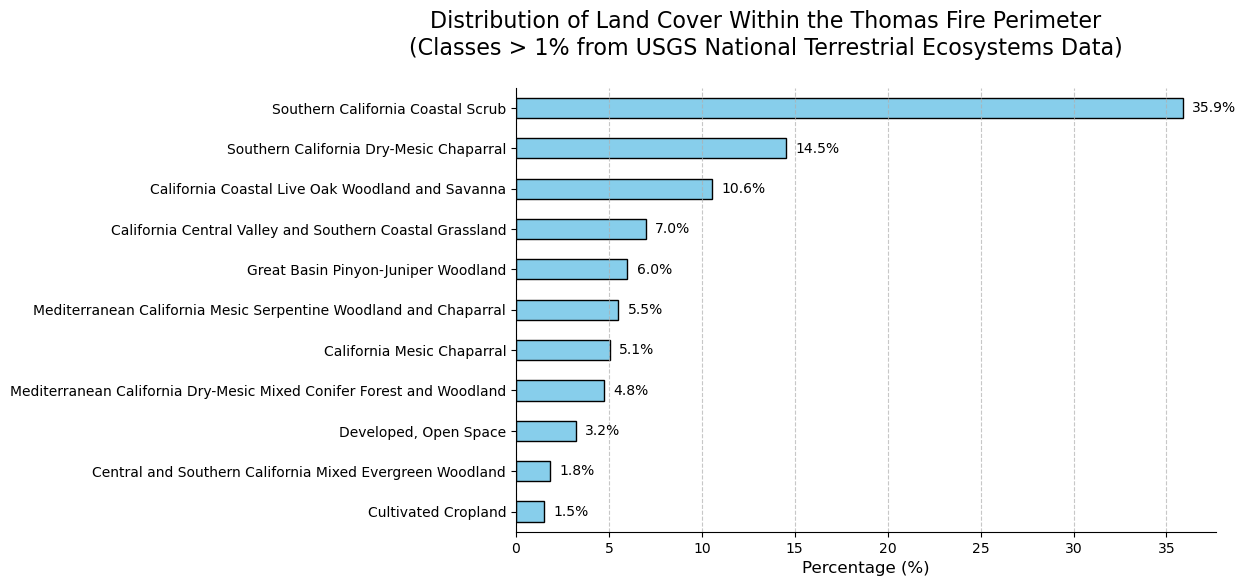

In [84]:
# Filter and set index as in the original code
filtered_classes = classes[classes['percentage'] > 1].set_index('class_label')

# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted figure size for better proportions

# Plot with improved style
filtered_classes.percentage.plot(
    kind='barh',
    ax=ax,
    color='skyblue',
    edgecolor='black'
)

# Add an improved title and center it relative to the entire figure
fig.suptitle(
    'Distribution of Land Cover Within the Thomas Fire Perimeter\n(Classes > 1% from USGS National Terrestrial Ecosystems Data)',
    fontsize=16,
    y=0.98  # Adjust position slightly for spacing
)

# Add axis labels
ax.set_xlabel('Percentage (%)', fontsize=12)
ax.set_ylabel('')  # No label for y-axis

# Add gridlines for easier interpretation
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage values to the bars
for i, v in enumerate(filtered_classes.percentage):
    ax.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=10)

# Remove top and right edges of the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make the axis box wider relative to the figure area
fig.subplots_adjust(left=0.25, right=0.95, top=0.85)  # Adjust spacing for the centered title

# Show the plot
plt.show()

In [82]:
<!--
```{python}
# Filter and set index as in the original code
filtered_classes = classes[classes['percentage']>1].set_index('class_label')

# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted figure size for better proportions

# Plot with improved style
filtered_classes.percentage.plot(
    kind='barh',
    ax=ax,
    color='skyblue',
    edgecolor='black'
)

# Add an improved title and center it relative to the entire figure
fig.suptitle(
    'Distribution of Land Cover Within the Thomas Fire Perimeter\n(Classes > 1% from USGS National Terrestrial Ecosystems Data)',
    fontsize=16,
    y=0.98  # Adjust position slightly for spacing
)

# Add axis labels
ax.set_xlabel('Percentage (%)', fontsize=12)
ax.set_ylabel('')  # No label for y-axis

# Add gridlines for easier interpretation
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage values to the bars
for i, v in enumerate(filtered_classes.percentage):
    ax.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=10)

# Remove top and right edges of the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make the axis box wider relative to the figure area
fig.subplots_adjust(left=0.25, right=0.95, top=0.85)  # Adjust spacing for the centered title

# Show the plot
plt.show()

SyntaxError: invalid syntax (1274069303.py, line 1)